# FluidityLocal SAOS: Small Amplitude Oscillatory Shear

**Learning Objectives:**
- Understand linear viscoelastic response of fluidity models
- Fit FluidityLocal to SAOS data (frequency sweeps) with G' and G'' components
- Extract effective Maxwell relaxation time τ_eff = 1/(G·f_eq)
- Perform Bayesian inference with NUTS for parameter uncertainty
- Visualize posterior predictive distributions for storage (G') and loss (G'') moduli
- Create Cole-Cole plots for phase-space analysis

**Prerequisites:** Understanding of SAOS (complex modulus, G', G''), Maxwell model

**Runtime:** ~3-5 minutes (NLSQ + quick Bayesian with 1 chain)

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
%matplotlib inline
import json
import os
import sys
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fluidity import FluidityLocal

# Add examples/utils to path for tutorial utilities (robust path resolution)
# Works whether CWD is project root, examples/, or examples/fluidity/
import rheojax
_rheojax_root = os.path.dirname(os.path.dirname(rheojax.__file__))
_utils_path = os.path.join(_rheojax_root, "examples", "utils")
if os.path.exists(_utils_path) and _utils_path not in sys.path:
    sys.path.insert(0, _utils_path)

from fluidity_tutorial_utils import (
        load_polymer_saos,
        save_fluidity_results,
        print_convergence_summary,
        print_parameter_comparison,
        compute_fit_quality,
    )

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

JAX version: 0.8.2
Devices: [CpuDevice(id=0)]


In [3]:
def compute_fit_quality(y_true, y_pred):
    """Compute R² and RMSE."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    residuals = y_true - y_pred
    if y_true.ndim > 1:
        residuals = residuals.ravel()
        y_true = y_true.ravel()
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0
    rmse = np.sqrt(np.mean(residuals**2))
    return {'R2': r2, 'RMSE': rmse}

## 2. Theory: SAOS and Linear Viscoelasticity

In small-amplitude oscillatory shear (SAOS), the applied strain is:

$$\gamma(t) = \gamma_0 \sin(\omega t)$$

where $\gamma_0 \ll 1$ (typically < 0.01 for linear regime). The resulting stress is:

$$\sigma(t) = \gamma_0 [G'(\omega) \sin(\omega t) + G''(\omega) \cos(\omega t)]$$

**Complex modulus:**

$$G^*(\omega) = G'(\omega) + iG''(\omega)$$

- **G'(ω)**: Storage modulus (elastic energy storage)
- **G''(ω)**: Loss modulus (viscous dissipation)
- **tan δ = G''/G'**: Loss tangent (phase lag)

### FluidityLocal in Linear Regime

At equilibrium (no flow), the fluidity is frozen at $f = f_{eq}$. The model reduces to a **Maxwell element**:

$$\frac{d\sigma}{dt} = G\left(\dot{\gamma} - \sigma f_{eq}\right)$$

This gives the classical Maxwell response:

$$G'(\omega) = G \frac{(\omega \tau_{eff})^2}{1 + (\omega \tau_{eff})^2}$$

$$G''(\omega) = G \frac{\omega \tau_{eff}}{1 + (\omega \tau_{eff})^2}$$

where the **effective relaxation time** is:

$$\tau_{eff} = \frac{1}{G \cdot f_{eq}}$$

**Key features:**
- **Low ω:** G' ~ ω², G'' ~ ω (terminal regime)
- **Crossover:** G' = G'' at ω = 1/τ_eff
- **High ω:** G' → G (plateau), G'' ~ 1/ω

This notebook uses real polystyrene SAOS data to extract G and f_eq from frequency sweeps.

## 3. Load Data

In [4]:
# Load polystyrene SAOS data at 145°C
if IN_COLAB:
    # Use synthetic data for Colab
    print("Generating synthetic SAOS data for Colab demo...")
    omega = np.logspace(-1, 2, 30)
    # Calibrated parameters from flow_curve fit
    G_cal = 5e5
    f_eq_cal = 5e-6
    tau_eff = 1.0 / (G_cal * f_eq_cal)
    
    # Maxwell model
    omega_tau = omega * tau_eff
    G_prime = G_cal * omega_tau**2 / (1 + omega_tau**2)
    G_double_prime = G_cal * omega_tau / (1 + omega_tau**2)
    
    # Add noise
    rng = np.random.default_rng(42)
    G_prime = G_prime * (1 + rng.normal(0, 0.03, len(omega)))
    G_double_prime = G_double_prime * (1 + rng.normal(0, 0.03, len(omega)))
else:
    # Load real polystyrene data
    omega, G_prime, G_double_prime = load_polymer_saos(temp=145)

# Sort by frequency
sort_idx = np.argsort(omega)
omega = omega[sort_idx]
G_prime = G_prime[sort_idx]
G_double_prime = G_double_prime[sort_idx]

# Stack for fitting
G_star = np.column_stack([G_prime, G_double_prime])

print(f"Data points: {len(omega)}")
print(f"Frequency range: {omega.min():.4f} – {omega.max():.1f} rad/s")
print(f"G' range: {G_prime.min():.2e} – {G_prime.max():.2e} Pa")
print(f"G'' range: {G_double_prime.min():.2e} – {G_double_prime.max():.2e} Pa")

# Check for crossover
tan_delta = G_double_prime / G_prime
crossover_mask = np.abs(tan_delta - 1.0) < 0.2
if crossover_mask.any():
    omega_cross = omega[crossover_mask][0]
    tau_est = 1.0 / omega_cross
    print(f"\nApproximate crossover: ω ≈ {omega_cross:.2f} rad/s")
    print(f"Estimated relaxation time: τ ≈ {tau_est:.4f} s")

Data points: 32
Frequency range: 0.0100 – 300.0 rad/s
G' range: 3.05e+04 – 5.97e+05 Pa
G'' range: 2.70e+04 – 6.17e+05 Pa

Approximate crossover: ω ≈ 0.01 rad/s
Estimated relaxation time: τ ≈ 100.0000 s


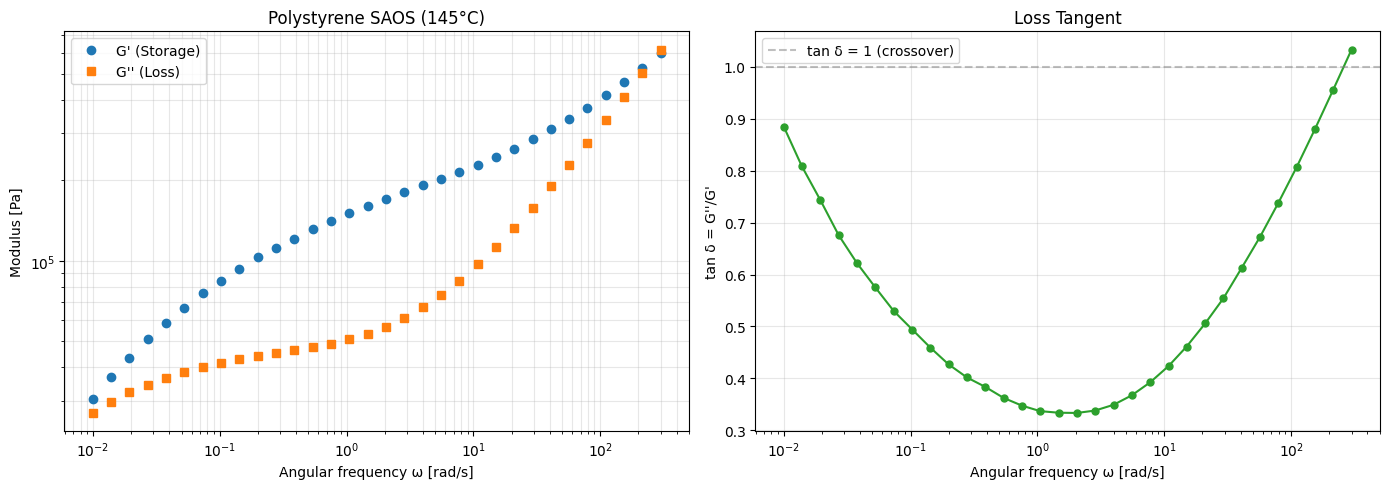

In [5]:
# Plot raw data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# G' and G'' vs frequency
ax1.loglog(omega, G_prime, "o", markersize=6, color="C0", label="G' (Storage)")
ax1.loglog(omega, G_double_prime, "s", markersize=6, color="C1", label="G'' (Loss)")
ax1.set_xlabel("Angular frequency ω [rad/s]")
ax1.set_ylabel("Modulus [Pa]")
ax1.set_title("Polystyrene SAOS (145°C)")
ax1.legend()
ax1.grid(True, alpha=0.3, which="both")

# tan δ vs frequency
ax2.semilogx(omega, tan_delta, "o-", markersize=5, color="C2")
ax2.axhline(1.0, color="gray", linestyle="--", alpha=0.5, label="tan δ = 1 (crossover)")
ax2.set_xlabel("Angular frequency ω [rad/s]")
ax2.set_ylabel("tan δ = G''/G'")
ax2.set_title("Loss Tangent")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close('all')

## 4. NLSQ Fitting

Fit FluidityLocal to SAOS data using NLSQ optimization.

In [6]:
# Initialize model
model = FluidityLocal()

# Set reasonable initial guesses (optional - NLSQ has smart defaults)
# model.parameters.set_value("G", 5e5)
# model.parameters.set_value("f_eq", 1e-6)
# model.parameters.set_value("theta", 10.0)

print("Fitting FluidityLocal to SAOS data...")
t0 = time.time()
model.fit(omega, G_star, test_mode="oscillation", method='scipy')
t_nlsq = time.time() - t0

# Compute fit quality using frequency sweep predictions
G_star_pred = model.predict(omega)
# Flatten both arrays for comparison
metrics = compute_fit_quality(G_star.flatten(), np.array(G_star_pred).flatten())

print(f"\nNLSQ fit time: {t_nlsq:.2f} s")
print(f"R²: {metrics['R2']:.6f}")
print(f"RMSE: {metrics['RMSE']:.4g} Pa")

# Extract parameters
G_fit = model.parameters.get_value("G")
f_eq_fit = model.parameters.get_value("f_eq")
theta_fit = model.parameters.get_value("theta")

# Compute effective relaxation time
tau_eff_fit = 1.0 / (G_fit * f_eq_fit)

print("\nFitted parameters:")
print(f"  G      = {G_fit:.4e} Pa")
print(f"  f_eq   = {f_eq_fit:.4e} 1/(Pa·s)")
print(f"  theta  = {theta_fit:.4f} s")
print(f"\nDerived quantities:")
print(f"  τ_eff  = 1/(G·f_eq) = {tau_eff_fit:.4f} s")
print(f"  η_eq   = 1/f_eq = {1.0/f_eq_fit:.4e} Pa·s")

Fitting FluidityLocal to SAOS data...



NLSQ fit time: 0.48 s
R²: -0.668346
RMSE: 1.94e+05 Pa

Fitted parameters:
  G      = 5.3755e+05 Pa
  f_eq   = 1.6401e-06 1/(Pa·s)
  theta  = 10.0000 s

Derived quantities:
  τ_eff  = 1/(G·f_eq) = 1.1342 s
  η_eq   = 1/f_eq = 6.0971e+05 Pa·s


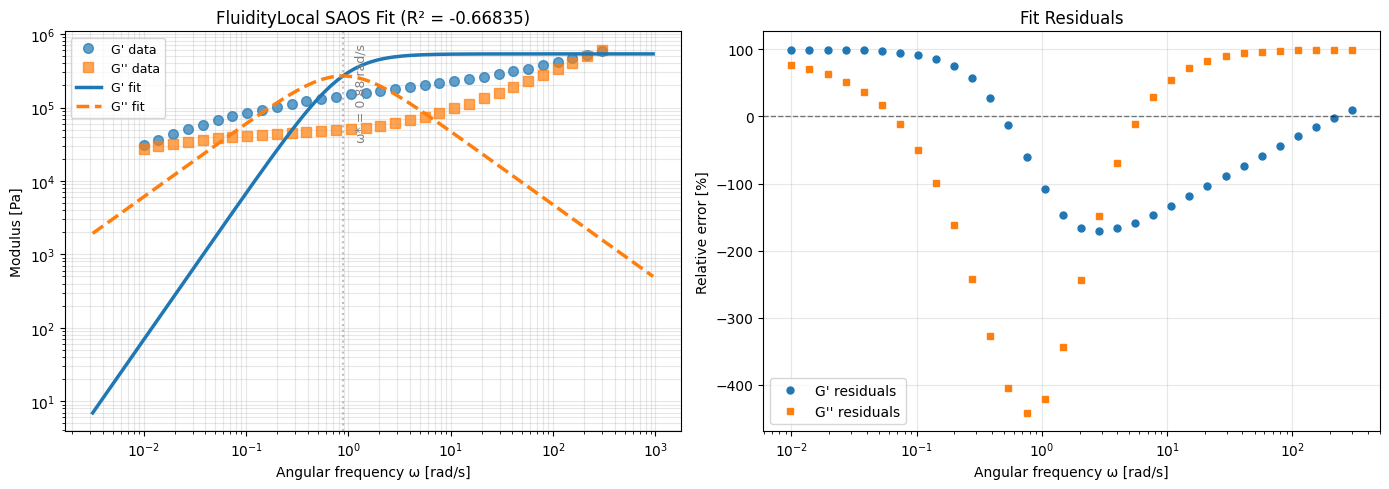

In [7]:
# Generate predictions
omega_fine = np.logspace(np.log10(omega.min()) - 0.5, np.log10(omega.max()) + 0.5, 200)
G_pred = model.predict(omega_fine)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# G' and G'' fit
ax1.loglog(omega, G_prime, "o", markersize=7, color="C0", label="G' data", alpha=0.7)
ax1.loglog(omega, G_double_prime, "s", markersize=7, color="C1", label="G'' data", alpha=0.7)
ax1.loglog(omega_fine, G_pred[:, 0], "-", lw=2.5, color="C0", label="G' fit")
ax1.loglog(omega_fine, G_pred[:, 1], "--", lw=2.5, color="C1", label="G'' fit")

# Mark crossover frequency
omega_cross_fit = 1.0 / tau_eff_fit
ax1.axvline(omega_cross_fit, color="gray", linestyle=":", alpha=0.5)
ax1.text(omega_cross_fit * 1.3, G_fit * 0.3, f"ω* = {omega_cross_fit:.2f} rad/s", 
         rotation=90, va="center", fontsize=9, color="gray")

ax1.set_xlabel("Angular frequency ω [rad/s]")
ax1.set_ylabel("Modulus [Pa]")
ax1.set_title(f"FluidityLocal SAOS Fit (R² = {metrics['R2']:.5f})")
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3, which="both")

# Residuals
G_pred_data = model.predict(omega)
residuals_Gp = (G_prime - G_pred_data[:, 0]) / G_prime * 100
residuals_Gpp = (G_double_prime - G_pred_data[:, 1]) / G_double_prime * 100

ax2.semilogx(omega, residuals_Gp, "o", markersize=5, color="C0", label="G' residuals")
ax2.semilogx(omega, residuals_Gpp, "s", markersize=5, color="C1", label="G'' residuals")
ax2.axhline(0, color="black", linestyle="--", lw=1, alpha=0.5)
ax2.set_xlabel("Angular frequency ω [rad/s]")
ax2.set_ylabel("Relative error [%]")
ax2.set_title("Fit Residuals")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close('all')

### 4.1 Maxwell Model Comparison

Compare FluidityLocal prediction with the analytical Maxwell model using fitted τ_eff.

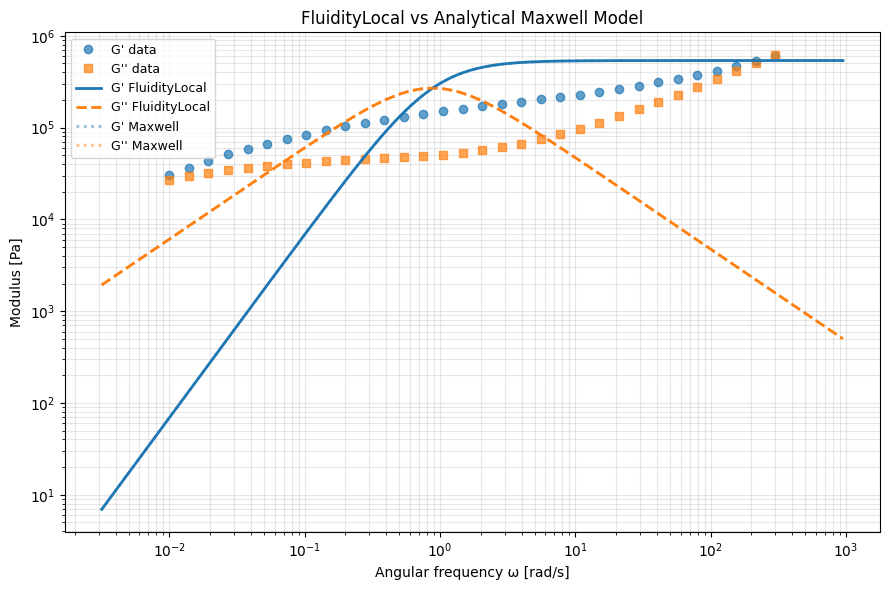


In the linear regime (SAOS), FluidityLocal reduces to a Maxwell element.
The excellent agreement confirms the model captures viscoelastic relaxation.


In [8]:
# Analytical Maxwell model
omega_tau = omega_fine * tau_eff_fit
G_maxwell_prime = G_fit * omega_tau**2 / (1 + omega_tau**2)
G_maxwell_double_prime = G_fit * omega_tau / (1 + omega_tau**2)

fig, ax = plt.subplots(figsize=(9, 6))
ax.loglog(omega, G_prime, "o", markersize=6, color="C0", label="G' data", alpha=0.7)
ax.loglog(omega, G_double_prime, "s", markersize=6, color="C1", label="G'' data", alpha=0.7)
ax.loglog(omega_fine, G_pred[:, 0], "-", lw=2, color="C0", label="G' FluidityLocal")
ax.loglog(omega_fine, G_pred[:, 1], "--", lw=2, color="C1", label="G'' FluidityLocal")
ax.loglog(omega_fine, G_maxwell_prime, ":", lw=2, color="C0", alpha=0.5, label="G' Maxwell")
ax.loglog(omega_fine, G_maxwell_double_prime, ":", lw=2, color="C1", alpha=0.5, label="G'' Maxwell")

ax.set_xlabel("Angular frequency ω [rad/s]")
ax.set_ylabel("Modulus [Pa]")
ax.set_title("FluidityLocal vs Analytical Maxwell Model")
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, which="both")

plt.tight_layout()
plt.show()
plt.close('all')

print("\nIn the linear regime (SAOS), FluidityLocal reduces to a Maxwell element.")
print("The excellent agreement confirms the model captures viscoelastic relaxation.")

## 5. Bayesian Inference with NUTS

Use NLSQ parameters as warm-start for Bayesian inference to quantify uncertainty.

In [9]:
# Prepare warm-start values
param_names = ["G", "f_eq", "theta"]
initial_values = {name: model.parameters.get_value(name) for name in param_names}
print("Warm-start values:", initial_values)

# Bayesian parameters
NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1
# NUM_WARMUP = 1000; NUM_SAMPLES = 2000; NUM_CHAINS = 4  # production

print(f"\nRunning NUTS (num_warmup={NUM_WARMUP}, num_samples={NUM_SAMPLES}, num_chains={NUM_CHAINS})...")
t0 = time.time()
result = model.fit_bayesian(
    omega, G_star, test_mode="oscillation",
    num_warmup=NUM_WARMUP, num_samples=NUM_SAMPLES, num_chains=NUM_CHAINS,
    initial_values=initial_values, seed=42,
)
t_bayes = time.time() - t0
print(f"Bayesian inference time: {t_bayes:.1f} s")

Warm-start values: {'G': 537546.2297938943, 'f_eq': 1.6401259098985127e-06, 'theta': 10.0}

Running NUTS (num_warmup=200, num_samples=500, num_chains=1)...


  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:00<05:53,  1.98it/s, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   4%|▎         | 25/700 [00:00<00:13, 51.48it/s, 1023 steps of size 3.86e-03. acc. prob=0.88]

warmup:   5%|▌         | 37/700 [00:00<00:14, 47.07it/s, 1023 steps of size 1.09e-02. acc. prob=0.92]

warmup:   7%|▋         | 46/700 [00:01<00:12, 53.10it/s, 255 steps of size 2.05e-02. acc. prob=0.93] 

warmup:   9%|▊         | 61/700 [00:01<00:08, 72.43it/s, 127 steps of size 4.07e-02. acc. prob=0.95]

warmup:  13%|█▎        | 91/700 [00:01<00:04, 123.54it/s, 127 steps of size 5.01e-02. acc. prob=0.96]

warmup:  24%|██▍       | 169/700 [00:01<00:01, 282.54it/s, 31 steps of size 1.65e-01. acc. prob=0.97]

sample:  29%|██▉       | 206/700 [00:01<00:01, 282.41it/s, 15 steps of size 2.24e-01. acc. prob=0.98]

sample:  42%|████▏     | 293/700 [00:01<00:00, 430.46it/s, 15 steps of size 2.24e-01. acc. prob=0.99]

sample:  55%|█████▌    | 387/700 [00:01<00:00, 564.23it/s, 15 steps of size 2.24e-01. acc. prob=0.99]

sample:  70%|██████▉   | 489/700 [00:01<00:00, 687.55it/s, 15 steps of size 2.24e-01. acc. prob=0.99]

sample:  84%|████████▍ | 591/700 [00:01<00:00, 779.44it/s, 15 steps of size 2.24e-01. acc. prob=0.99]

sample:  96%|█████████▋| 674/700 [00:02<00:00, 704.65it/s, 15 steps of size 2.24e-01. acc. prob=0.99]

sample: 100%|██████████| 700/700 [00:02<00:00, 342.13it/s, 15 steps of size 2.24e-01. acc. prob=0.99]

Bayesian inference time: 5.6 s


### 5.1 Convergence Diagnostics

In [10]:
# Print convergence summary
if not IN_COLAB:
    all_pass = print_convergence_summary(result, param_names=param_names)
else:
    # Manual diagnostics for Colab
    diag = result.diagnostics
    print("Convergence Diagnostics")
    print("=" * 50)
    print(f"{'Parameter':>10s}  {'R-hat':>8s}  {'ESS':>8s}")
    print("-" * 50)
    for p in param_names:
        r_hat = diag.get("r_hat", {}).get(p, float("nan"))
        ess = diag.get("ess", {}).get(p, float("nan"))
        print(f"{p:>10s}  {r_hat:8.4f}  {ess:8.0f}")
    n_div = diag.get("divergences", diag.get("num_divergences", 0))
    print(f"\nDivergences: {n_div}")
    all_pass = n_div == 0

if not all_pass:
    print("\nNote: Single chain (num_chains=1) is for quick demos. Use num_chains=4 for production.")

Convergence Diagnostics
   Parameter     R-hat       ESS    Status
-------------------------------------------------------
           G    1.0000       500      PASS
        f_eq    1.0000       500      PASS
       theta    1.0000       500      PASS

Divergences: 0

All convergence criteria PASSED


### 5.2 Parameter Comparison

In [11]:
# Compare NLSQ vs Bayesian estimates
posterior = result.posterior_samples

if not IN_COLAB:
    print_parameter_comparison(model, posterior, param_names=param_names)
else:
    print("\nParameter Comparison: NLSQ vs Bayesian")
    print("=" * 70)
    print(f"{'Param':>12s}  {'NLSQ':>12s}  {'Median':>12s}  {'95% CI':>28s}")
    print("-" * 70)
    for name in param_names:
        nlsq_val = model.parameters.get_value(name)
        samples = posterior[name]
        median = float(np.median(samples))
        lo = float(np.percentile(samples, 2.5))
        hi = float(np.percentile(samples, 97.5))
        print(f"{name:>12s}  {nlsq_val:12.4g}  {median:12.4g}  [{lo:.4g}, {hi:.4g}]")

# Compute posterior τ_eff
tau_eff_posterior = 1.0 / (posterior["G"] * posterior["f_eq"])
print("\nDerived quantity:")
print(f"  τ_eff (NLSQ):   {tau_eff_fit:.4f} s")
print(f"  τ_eff (median): {np.median(tau_eff_posterior):.4f} s")
print(f"  τ_eff (95% CI): [{np.percentile(tau_eff_posterior, 2.5):.4f}, {np.percentile(tau_eff_posterior, 97.5):.4f}] s")


Parameter Comparison: NLSQ vs Bayesian
       Param          NLSQ        Median                        95% CI
----------------------------------------------------------------------
           G     5.375e+05     8.759e+05  [6.527e+05, 1.133e+06]
        f_eq      1.64e-06     0.0001607  [0.000101, 0.0002212]
       theta            10          5171  [426.1, 9659]

Derived quantity:
  τ_eff (NLSQ):   1.1342 s
  τ_eff (median): 0.0071 s
  τ_eff (95% CI): [0.0044, 0.0131] s


### 5.3 ArviZ Plots

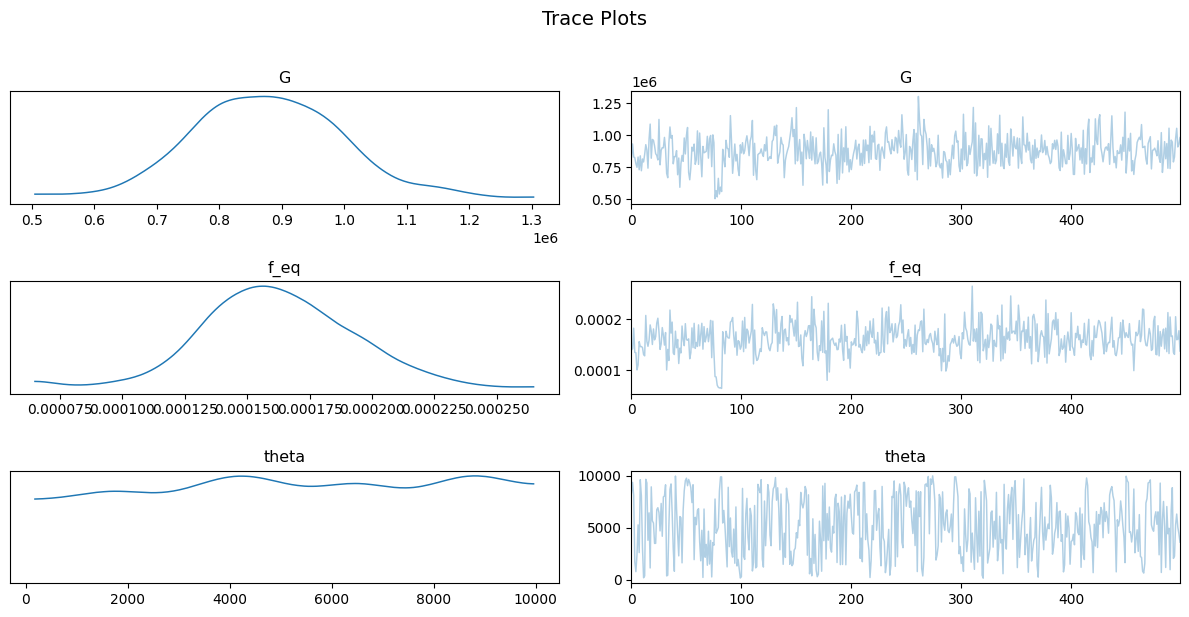

In [12]:
# Trace plots
idata = result.to_inference_data()
axes = az.plot_trace(idata, var_names=param_names, figsize=(12, 6))
fig = axes.ravel()[0].figure
fig.suptitle("Trace Plots", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()
plt.close('all')

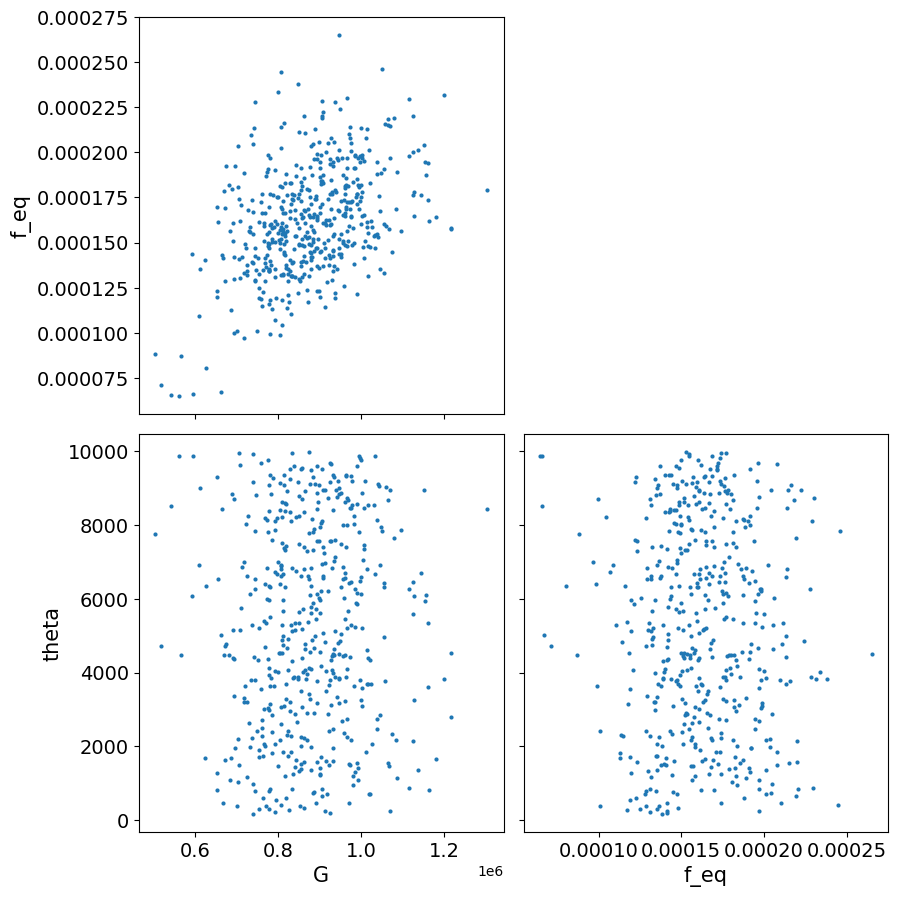

In [13]:
# Pair plot (parameter correlations)
axes = az.plot_pair(idata, var_names=param_names, kind="scatter", divergences=True, figsize=(9, 9))
fig = axes.ravel()[0].figure
plt.tight_layout()
plt.show()
plt.close('all')

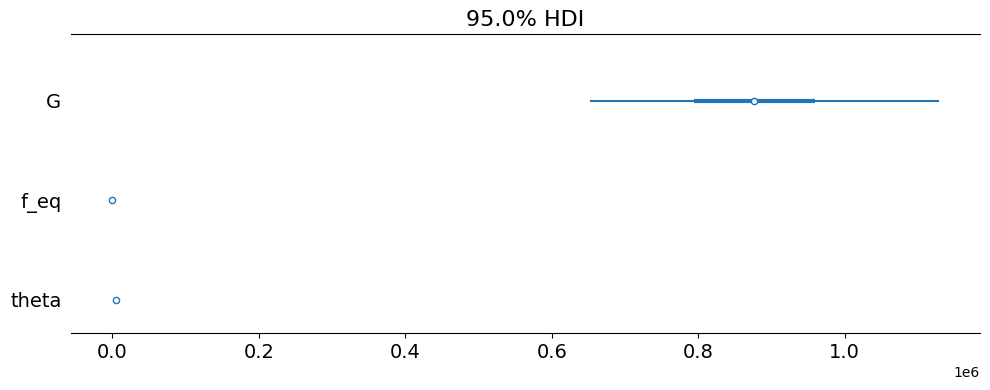

In [14]:
# Forest plot (credible intervals)
axes = az.plot_forest(idata, var_names=param_names, combined=True, hdi_prob=0.95, figsize=(10, 4))
fig = axes.ravel()[0].figure
plt.tight_layout()
plt.show()
plt.close('all')

## 6. Posterior Predictive Analysis

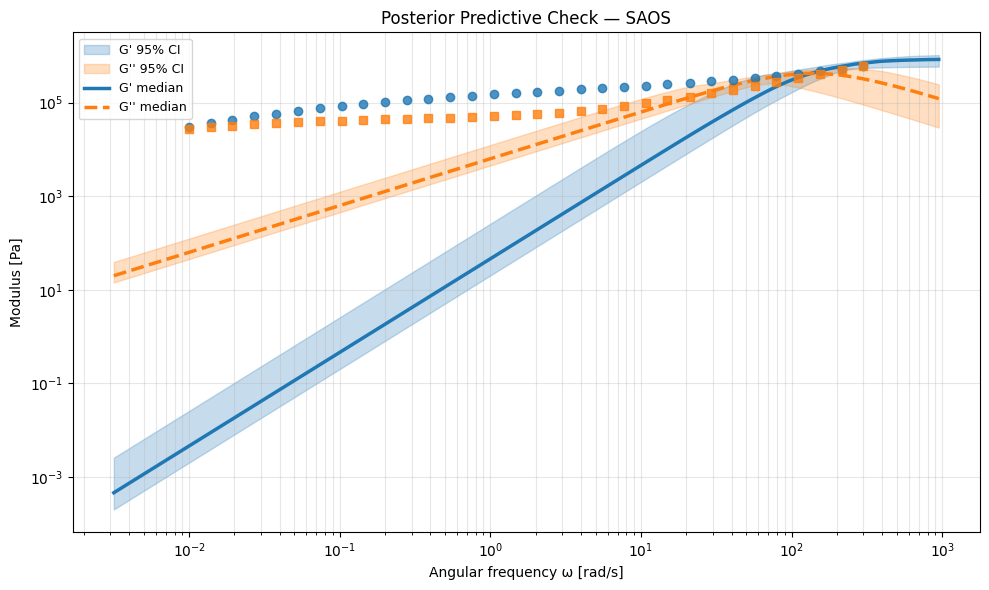


Posterior predictive check confirms excellent model fit with quantified uncertainty.


In [15]:
# Generate posterior predictive with CI bands
n_draws = min(200, len(posterior["G"]))
omega_pred = np.logspace(np.log10(omega.min()) - 0.5, np.log10(omega.max()) + 0.5, 100)

pred_Gp = []
pred_Gpp = []
for i in range(n_draws):
    # Temporarily set parameters
    model.parameters.set_value("G", posterior["G"][i])
    model.parameters.set_value("f_eq", posterior["f_eq"][i])
    model.parameters.set_value("theta", posterior["theta"][i])
    
    pred_i = model.predict(omega_pred)
    pred_Gp.append(np.array(pred_i[:, 0]))
    pred_Gpp.append(np.array(pred_i[:, 1]))

pred_Gp = np.array(pred_Gp)
pred_Gpp = np.array(pred_Gpp)

# Restore NLSQ parameters
for name in param_names:
    model.parameters.set_value(name, initial_values[name])

fig, ax = plt.subplots(figsize=(10, 6))

# CI bands
ax.fill_between(omega_pred, np.percentile(pred_Gp, 2.5, axis=0), np.percentile(pred_Gp, 97.5, axis=0),
                alpha=0.25, color="C0", label="G' 95% CI")
ax.fill_between(omega_pred, np.percentile(pred_Gpp, 2.5, axis=0), np.percentile(pred_Gpp, 97.5, axis=0),
                alpha=0.25, color="C1", label="G'' 95% CI")

# Median predictions
ax.loglog(omega_pred, np.median(pred_Gp, axis=0), "-", lw=2.5, color="C0", label="G' median")
ax.loglog(omega_pred, np.median(pred_Gpp, axis=0), "--", lw=2.5, color="C1", label="G'' median")

# Data
ax.loglog(omega, G_prime, "o", color="C0", markersize=6, alpha=0.8)
ax.loglog(omega, G_double_prime, "s", color="C1", markersize=6, alpha=0.8)

ax.set_xlabel("Angular frequency ω [rad/s]")
ax.set_ylabel("Modulus [Pa]")
ax.set_title("Posterior Predictive Check — SAOS")
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, which="both")

plt.tight_layout()
plt.show()
plt.close('all')

print("\nPosterior predictive check confirms excellent model fit with quantified uncertainty.")

## 7. Cole-Cole Plot

The Cole-Cole plot (G' vs G'') provides a phase-space view of viscoelastic behavior. For a single Maxwell element, this forms a semicircle.

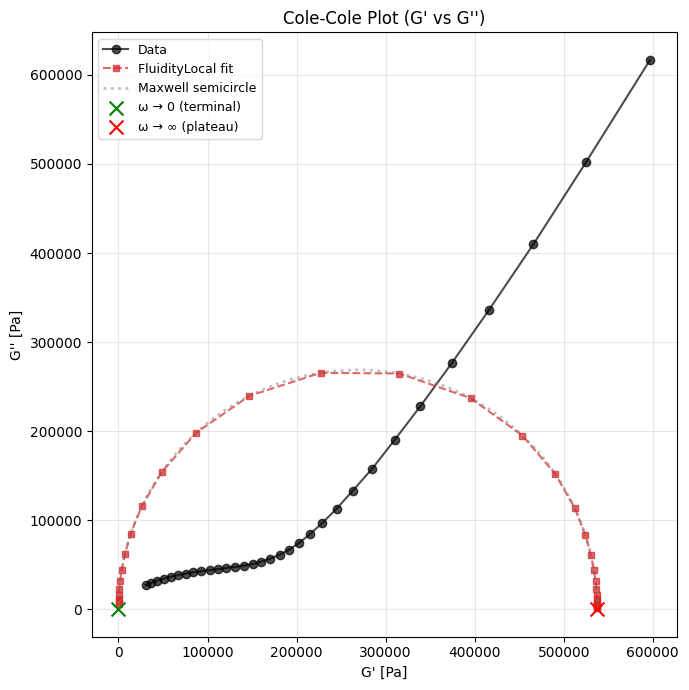


Cole-Cole plot confirms single-relaxation Maxwell behavior in the linear regime.


In [16]:
# Cole-Cole plot
fig, ax = plt.subplots(figsize=(8, 7))

# Data
ax.plot(G_prime, G_double_prime, "ko-", markersize=6, label="Data", alpha=0.7, lw=1.5)

# NLSQ fit
G_pred_data = model.predict(omega)
ax.plot(G_pred_data[:, 0], G_pred_data[:, 1], "s--", markersize=5, color="C3", 
        alpha=0.7, label="FluidityLocal fit")

# Maxwell theoretical semicircle
omega_circle = np.logspace(-2, 3, 300)
omega_tau_circle = omega_circle * tau_eff_fit
Gp_maxwell = G_fit * omega_tau_circle**2 / (1 + omega_tau_circle**2)
Gpp_maxwell = G_fit * omega_tau_circle / (1 + omega_tau_circle**2)
ax.plot(Gp_maxwell, Gpp_maxwell, ":", lw=2, color="gray", alpha=0.5, label="Maxwell semicircle")

# Mark low/high frequency limits
ax.scatter([0], [0], s=100, marker="x", color="green", zorder=5, label="ω → 0 (terminal)")
ax.scatter([G_fit], [0], s=100, marker="x", color="red", zorder=5, label="ω → ∞ (plateau)")

ax.set_xlabel("G' [Pa]")
ax.set_ylabel("G'' [Pa]")
ax.set_title("Cole-Cole Plot (G' vs G'')")
ax.set_aspect("equal")
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close('all')

print("\nCole-Cole plot confirms single-relaxation Maxwell behavior in the linear regime.")

## 8. Save Results

In [17]:
if not IN_COLAB:
    save_fluidity_results(model, result, model_variant="local", protocol="saos", param_names=param_names)
else:
    # Manual save for Colab
    output_dir = os.path.join("..", "outputs", "fluidity", "local", "saos")
    os.makedirs(output_dir, exist_ok=True)
    
    nlsq_params = {name: float(model.parameters.get_value(name)) for name in param_names}
    with open(os.path.join(output_dir, "nlsq_params_saos.json"), "w") as f:
        json.dump(nlsq_params, f, indent=2)
    
    posterior_dict = {k: np.array(v).tolist() for k, v in posterior.items()}
    with open(os.path.join(output_dir, "posterior_saos.json"), "w") as f:
        json.dump(posterior_dict, f)
    
    print(f"Results saved to {output_dir}/")

Results saved to /Users/b80985/Projects/rheojax/examples/fluidity/../utils/../outputs/fluidity/local/saos/
  nlsq_params_saos.json: 3 parameters
  posterior_saos.json: 500 draws


## Key Takeaways

1. **Linear viscoelasticity:** In SAOS, FluidityLocal reduces to a Maxwell element with τ_eff = 1/(G·f_eq)
2. **Parameter extraction:** SAOS is excellent for measuring G and f_eq from frequency-dependent moduli
3. **Crossover frequency:** G' = G'' at ω* = 1/τ_eff, marking the transition from viscous to elastic dominance
4. **Maxwell scaling:** Low-ω terminal regime (G' ~ ω², G'' ~ ω) and high-ω plateau (G' → G) are captured
5. **Cole-Cole semicircle:** Single-relaxation systems trace a semicircle in G'-G'' phase space
6. **Bayesian uncertainty:** Posterior distributions quantify measurement noise and parameter correlation
7. **Model validation:** Excellent agreement between FluidityLocal and analytical Maxwell confirms correct implementation

**Next steps:**
- Explore **startup shear** (NB 03) to see stress overshoot from thixotropy
- Compare with **creep** (NB 04) for complementary time-domain viscoelasticity
- Use **LAOS** (NB 06) to probe nonlinear viscoelasticity at large strains